Here we demonstrate how to use SHAP values to understand XGBoost model predictions.

Source: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [77]:
!pip install shap

In [78]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [102]:
url = 'https://raw.githubusercontent.com/sarahyurick/datasets/master/diabetes.csv'
dataset = pd.read_csv(url)
train_data, test_data = train_test_split(dataset, test_size=0.2)
print(len(train_data), 'train examples')
print(len(test_data), 'test examples')
X_train = train_data.iloc[:,:8]
y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:,:8]
y_test = test_data.iloc[:,-1]

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

X = pd.concat([X_train, X_test])
Y = pd.concat([y_train, y_test])

614 train examples
154 test examples


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [103]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.620129
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.516718
Stopping. Best iteration:
[167]	test-logloss:0.503842



Here we try out the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

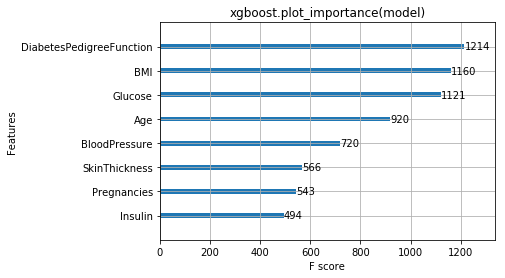

In [81]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

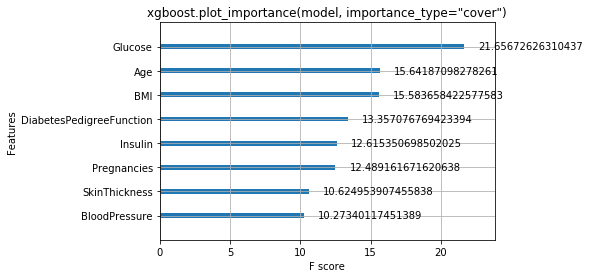

In [82]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

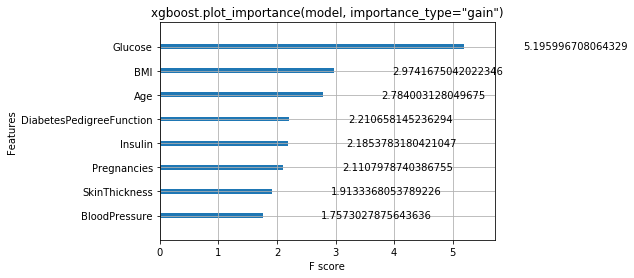

In [83]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

In [0]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Visualize a single prediction. Note that we use the "display values" data frame so we get nice strings instead of category codes.

In [85]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


Visualize many predictions. 

In [86]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

Bar chart of mean importance. This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart. 

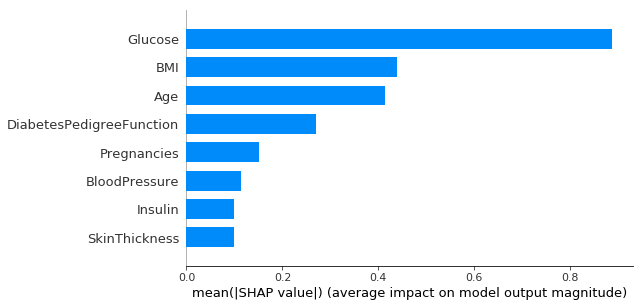

In [87]:
shap.summary_plot(shap_values, X, plot_type="bar")


SHAP Summary Plot. Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

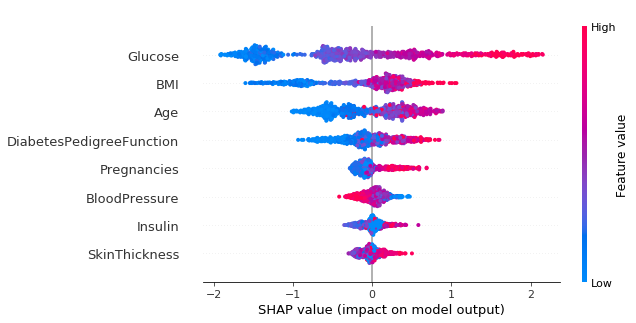

In [88]:
shap.summary_plot(shap_values, X)


SHAP Dependence Plots. SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

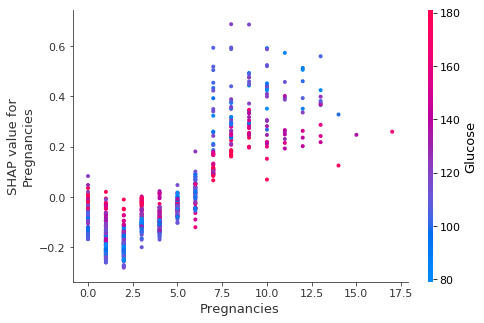

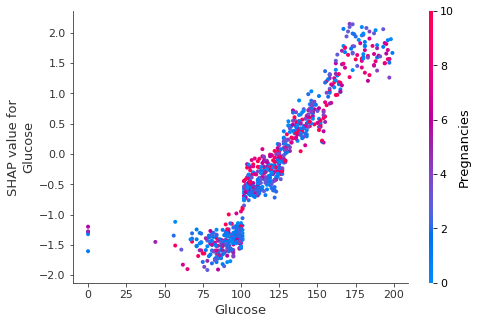

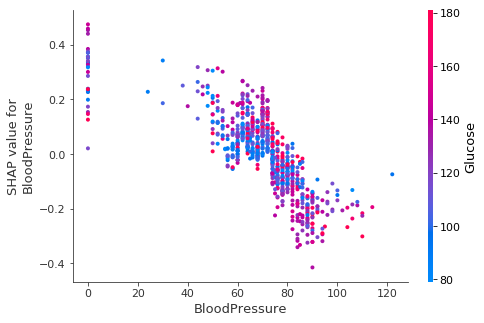

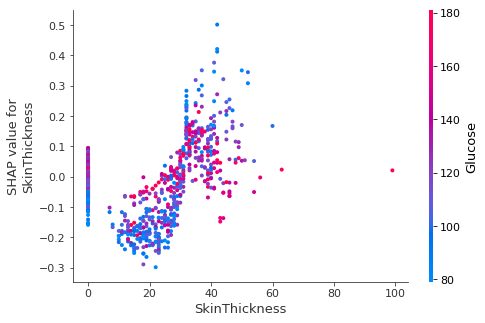

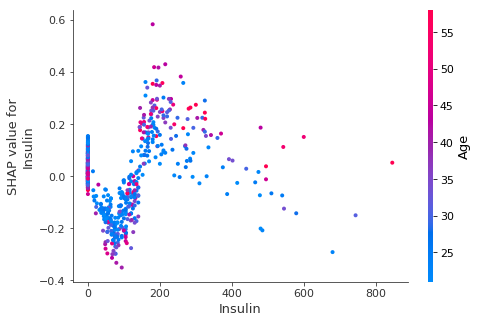

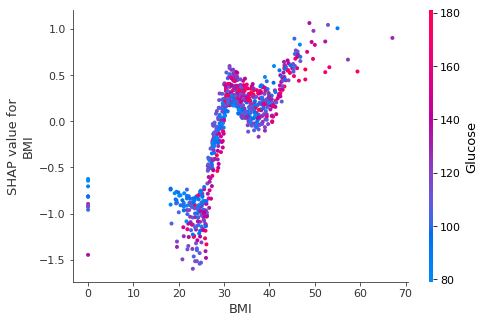

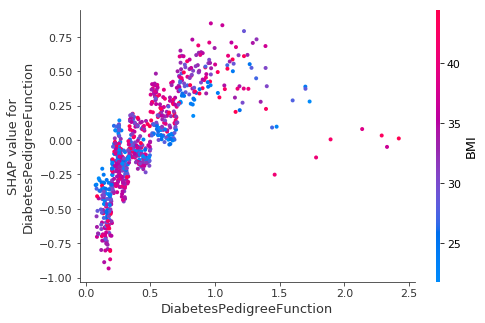

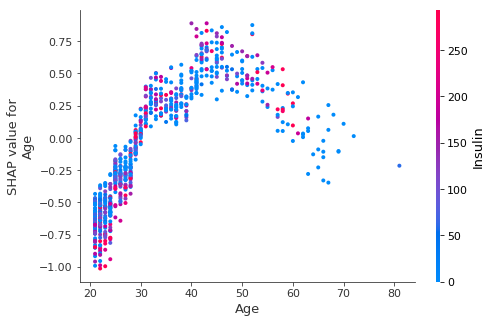

In [89]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)

In [90]:
train_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
576,6,108,44,20,130,24.0,0.813,35,0
614,11,138,74,26,144,36.1,0.557,50,1
502,6,0,68,41,0,39.0,0.727,41,1
722,1,149,68,29,127,29.3,0.349,42,1
12,10,139,80,0,0,27.1,1.441,57,0


According to the above: SkinThickness and Insulin aren't all that important... so let's remove them and see if the exact same model works better. 

In [110]:
url = 'https://raw.githubusercontent.com/sarahyurick/datasets/master/diabetes.csv'
dataset = pd.read_csv(url)
train_data, test_data = train_test_split(dataset, test_size=0.2)
print(len(train_data), 'train examples')
print(len(test_data), 'test examples')
X_train = train_data[['Pregnancies','Glucose','BloodPressure','BMI','DiabetesPedigreeFunction','Age']]
y_train = train_data.iloc[:,-1]
X_test = test_data[['Pregnancies','Glucose','BloodPressure','BMI','DiabetesPedigreeFunction','Age']]
y_test = test_data.iloc[:,-1]

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

614 train examples
154 test examples


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [111]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.649161
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.509632
[200]	test-logloss:0.475232
[300]	test-logloss:0.466937
Stopping. Best iteration:
[303]	test-logloss:0.466458



Conclusion: Removing these features might help a little (since a lower logloss is better), but probably only by chance!